<a href="https://colab.research.google.com/github/gbmrls/cvxopt_feature-engineering/blob/main/Tutorial_image_classification_with_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial: image classification with scikit-learn**

In this tutorial, we will set up a machine learning pipeline in scikit-learn to preprocess data and train a model. As a test case, we will classify animal photos, but of course the methods described can be applied to all kinds of machine learning problems. For this tutorial we used scikit-learn version 0.24 with Python 3.9.1, on Linux.
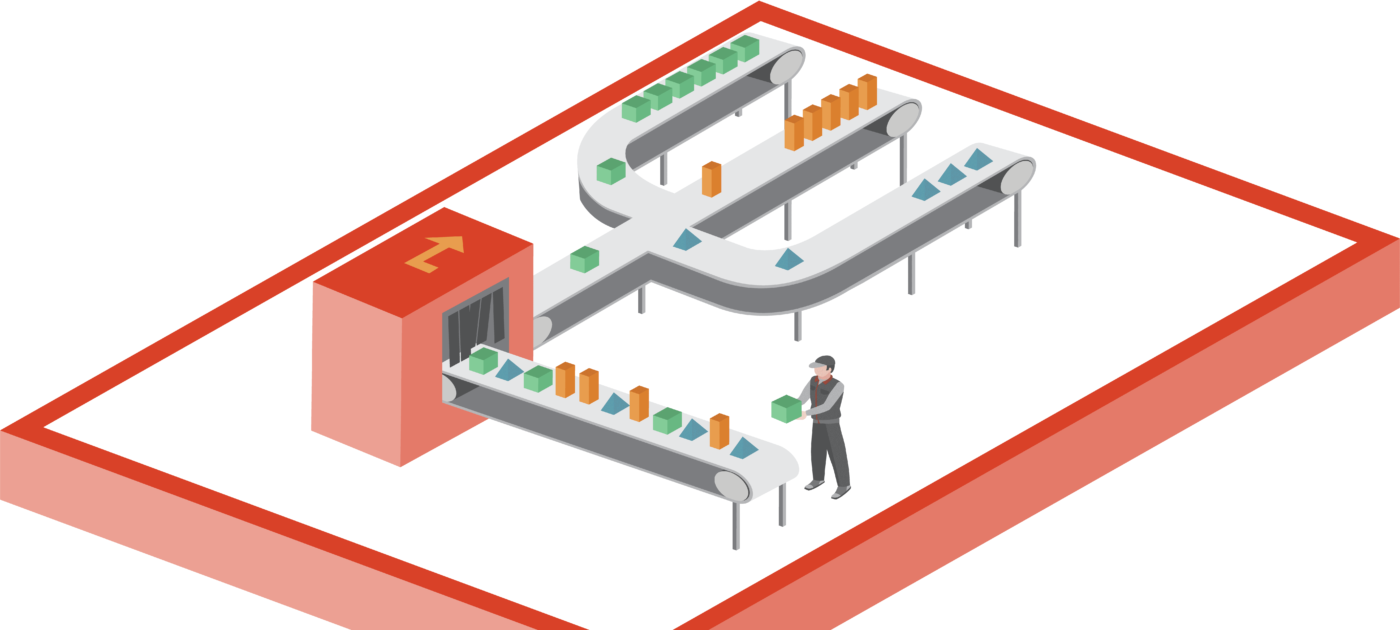


For ease of reading, we will place imports where they are first used, instead of collecting them at the start of the notebook. This to prevent having to scroll up and down to check how an import is exactly done.

Throughout the tutorial we will need arrays for our data and graphs for visualisation. Therefore, we import numpy and matplotlib. Furthermore, we start with some magic to specify that we want our graphs shown inline and we import pprint to make some output look nicer.

In [20]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Preparing the data set

The dataset that we will use can be found here and was published as part of this article.

Unzip the data to a folder, which will be the src path. Next, we define a function to read, resize and store the data in a dictionary, containing the images, labels (animal), original filenames, and a description. The images themselves are stored as numpy arrays containing their RGB values. The dictionary is saved to a pickle file using joblib. The data structure is based on that used for the test data sets in scikit-learn.

In [21]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [16]:
# modify to fit your system
data_path = '/content/drive/MyDrive/Optimizacion_Convexa/HW_08:GABO_FAB/Image'
data_path

'/content/drive/MyDrive/Optimizacion_Convexa/HW_08:GABO_FAB/Image'

In [18]:
os.listdir(data_path)

['WolfHead',
 'TigerHead',
 'SheepHead',
 'RabbitHead',
 'PigHead',
 'PigeonHead',
 'PandaHead',
 'Natural',
 'MouseHead',
 'MonkeyHead',
 'LionHead',
 'HumanHead',
 'ElephantHead',
 'EagleHead',
 'DuckHead',
 'DogHead',
 'DeerHead',
 'CowHead',
 'ChickenHead',
 'CatHead',
 'BearHead']

Now we create the dataset. Note this step is not required every time you run the notebook as the data is stored as a pkl, which can be loaded directly next time.

There are quite some animals included in the dataset, but we will only use the selection defined below. Also we set the width (and height) to 80 pixels.

In [19]:
base_name = 'animal_faces'
width = 80
 
include = {'ChickenHead', 'BearHead', 'ElephantHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead'}
# We apply the function defined at the begining 
resize_all(src=data_path, pklname=base_name, width=width, include=include)


PandaHead
MonkeyHead
ElephantHead
EagleHead
DeerHead
ChickenHead
BearHead


Let’s load the data from disk and print a summary.



In [23]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', (data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  716
keys:  dict_keys(['description', 'label', 'filename', 'data'])
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['Bear' 'Chicken' 'Deer' 'Eagle' 'Elephant' 'Monkey' 'Panda']


Counter({'Bear': 101,
         'Chicken': 100,
         'Deer': 101,
         'Eagle': 97,
         'Elephant': 100,
         'Monkey': 100,
         'Panda': 117})

The images below show an example of each animal included.



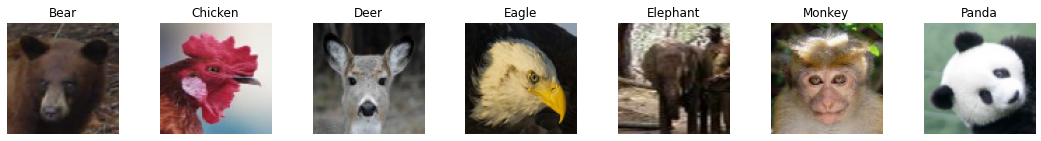

In [24]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

By convention, we name the input data X and result (labels) y.



In [25]:
X = np.array(data['data'])
y = np.array(data['label'])


Next, we need to split our data into a test set and a training set. We use the train_test_split function from scikit-learn and use 80% of the total set for training and the remaining for the test set. In the data set, the photos are ordered by animal, so we cannot simply split at 80%.

To understand why, let’s look at the table below. If the data is ordered and we split at some position, we will end up with some animals (types) appearing in only one of the two sets. For example, cows only appear in the test set. This is a problem, as in this way we will never train our model to recognise cows, and therefore it will not be able to predict them correctly.

We can solve this by shuffling the data prior to splitting. This way, we even out the distributions in the training and test set and make them comparable.

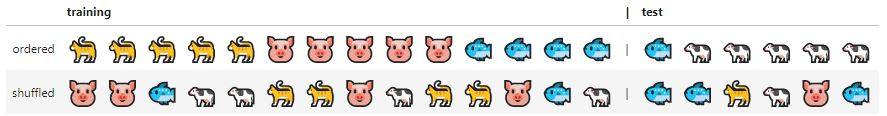

The train_test_split function in sklearn provides a shuffle parameter to take care of this while doing the split. The random_state seeds the shuffling so that it is random, but in a reproducible way.

In [26]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

To verify that the distribution of photos in the training and test set is similar, let’s look at the relative number of photos per category.



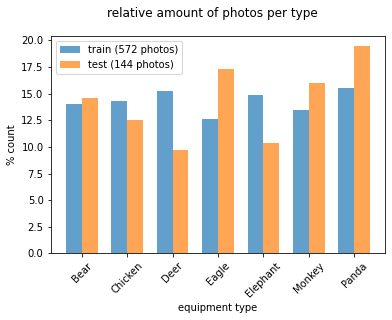

In [29]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);


The distributions are not perfectly equal, but good enough for now. Note that our data set is quite small (~100 photos per category), so 1 or 2 photos difference in the test set will have a big effect on the distribution. For further improvement, we could also use the stratify parameter of train_test_split to ensure equal distributions in the training and test set.

# Processing
A classic approach to object recognition is HOG-SVM, which stands for Histogram of Oriented Gradients and Support Vector Machines. HOGs are used for feature reduction, in other words: for lowering the complexity of the problem, while maintaining as much variation as possible.

To calculate a HOG, an image is divided into blocks, for example 8 by 8 pixels. For each of these blocks, the magnitude of the gradient in a given number of directions is calculated. 

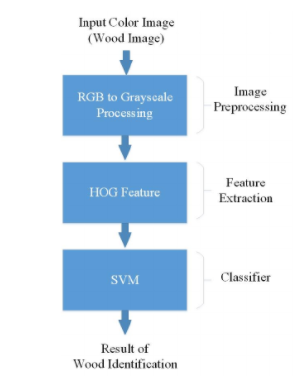

The methodology we are going to use is divided in the following steps:

A) *Object detection*

B) *Preprocessing of the Sample Images*

C) *Feature Extraction using HOG Method*

HOG features descriptor is that local object appearance and shape within an image can be described by the distribution of density distribution of gradients. The implementation of this descriptor can be achieved by dividing the image into small regions called a cell. Each cell compiles a histogram of gradient direction for the pixel within the cell. HOG method has four steps to extract the object. First step is calculating the gradient values by applying $1-D$ centered to obtain the point of discrete derivative mask in horizontal and vertical direction as follow:
$$
\begin{array}{l}
D_{x}=\left[\begin{array}{lll}
-1 & 0 & 1
\end{array}\right] \\
D_{y}=\left[\begin{array}{r}
1 \\
0 \\
-1
\end{array}\right]
\end{array}
$$
If the object image is $I$, we can obtain $x$ and $y$ derivative using convolution operation:
$$
I_{x}=I_{x} * D_{x} \quad \text { and } \quad I_{y}=I_{y} * D_{y}
$$
For calculating the magnitude of gradient, the formula is
$$
|G|=\sqrt{I_{x}^{2}+I_{y}^{2}}
$$
and for gradient orientation is given by
$$
\theta=\arctan \frac{I_{y}}{I_{x}}
$$

The second step is spatial orientation binning. This step has a function to give a result of cell histogram by a voting process. Each pixel of the image within the casts a weighted vote for orientation in accordance with the closest bin in the range 0 to 180 degrees. In the third step, there is the $\mathrm{HOG}$ descriptor to normalize cell and histogram from entire block region to be a vector form. The last step, the block normalization is performed by using the $\mathrm{L} 2$ norm as follow:
$$
b=\frac{b}{\sqrt{|| b||^{2}+\varepsilon^{2}}}
$$

After process HOG normalization, the windows descriptor is needed to collect descriptor from all the block and change into vector form. In this research, we use the $64 \times 128$ pixels detection window. This detection window will be divided into 7 blocks across and 15 blocks vertically then the total of the block is 105 blocks. Each block contains 4 cells with a 9 -bin histogram for each cell and the total of value per block is 36 values. Because of this dimension, the final vector size of 7 blocks across $x 15$ blocks vertically $x 4$ cells per block $x 9$ bins per histogram $=3,780$ values. This final vector is accommodated by the database for the input in the next step in classifier process.

(For a detailed explanation, we refer to http://www.learnopencv.com/histogram-of-oriented-gradients/)

Here we will just look at an example:

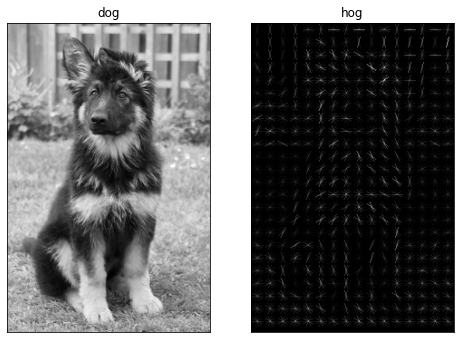

In [31]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('https://upload.wikimedia.org/wikipedia/commons/f/fa/Kim_at_14_weeks.jpg', as_gray=True)
# https://commons.wikimedia.org/wiki/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third
dog = rescale(dog, 1/3, mode='reflect')
# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(
    dog, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
plt.show()

In [32]:
print('number of pixels: ', dog.shape[0] * dog.shape[1])
print('number of hog features: ', dog_hog.shape[0])


number of pixels:  76384
number of hog features:  12420


The number of data points to process in our model has been reduced to ~15%, and with some imagination we can still recognise a dog in the HOG.

#Transformers
When calculating our HOG, we performed a transformation. We can transform our entire data set using transformers. These are objects that take in the array of data, transform each item and return the resulting data.

Here, we need to convert colour images to grayscale, calculate their HOGs and finally scale the data. For this, we use three transformers in a row: RGB2GrayTransformer, HOGTransformer and StandardScaler. The final result is an array with a HOG for every image in the input.

Scikit-learn comes with many built-in transformers, such as a StandardScaler to scale features and a Binarizer to map string features to numerical features. In addition, it provides the BaseEstimator and TransformerMixin classes to facilitate making your own Transformers.

A custom transformer can be made by inheriting from these two classes and implementing an __init__, fit and transform method. The TransformerMixin class provides the fit_transform method, which combines the fit and transform that we implemented.

Below, we define the RGB2GrayTransformer and HOGTransformer.

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Note that for compatibility with scikit-learn, the fit and transform methods take both X and y as parameters, even though y is not used here.

With this, we are all set to preprocess our RGB images to scaled HOG features.

In [35]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(572, 576)


# Training
The next step is to train a classifier. We will start with Stochastic Gradient Descent (SGD), because it is fast and works reasonably well.

First we create an instance and then we call the fit method passing our training data and labels.

In [36]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

# Testing
To test the trained SGD classifier, we will use our test set. First, we transform it using the same transformers as before. However, we must take care that our test data will not influence the transformers. Some transformers, like PCA (Principle Component Analysis), can optimise themselves on the data before applying the transformation. To prevent this, we call transform and not fit_transform on the test data.

In [37]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

Next, we make a prediction for our test set and look at the results. How many of the predictions match with y_test?

In [38]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[False  True  True False  True False  True  True  True  True  True  True
 False  True  True  True  True False  True  True  True  True  True  True
 False]

Percentage correct:  86.80555555555556


# Confusion matrix
A percentage like the above is nice, but it is not the whole story. What about false positives, for example? To get more insight in the results, we can use a correlation matrix. This is a table where each row corresponds to a label, and each column to a prediction.

We will illustrate this using a pandas dataframe with some yes/no data.

In [39]:
import pandas as pd

In [40]:
labels = ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no',  'no', 'no', 'no']
predictions = ['yes', 'yes', 'yes', 'yes', 'no',  'no',  'yes', 'no', 'no', 'no']
 
# put the data in a dataframe for pretty printing
df = pd.DataFrame(
    np.c_[labels, predictions], 
    columns=['true_label', 'prediction']
)
df

,true_label,prediction
0,yes,yes
1,yes,yes
2,yes,yes
3,yes,yes
4,yes,no
5,yes,no
6,no,yes
7,no,no
8,no,no
9,no,no


To create a confusion matrix, we use the confusion_matrix function from sklearn.metrics. Besides the two lists we created above, we also pass a labels array with the values of the labels. This is only to control the order in which they appear in the matrix. If we leave this out, they would appear sorted alphabetically. The columns give us the predictions, while along the index, we find the real labels.

In [41]:
from sklearn.metrics import confusion_matrix
 
label_names = ['yes', 'no']
cmx = confusion_matrix(labels, predictions, labels=label_names)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,yes,no
label,,
yes,4,2
no,1,3


The main diagonal corresponds to correct predictions. In this binary case, false positives show up below and false negatives above the diagonal.

Another way to represent this is in the form of a colormap image.

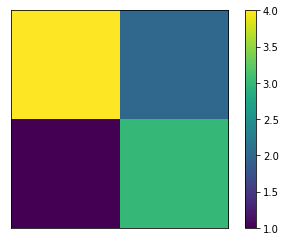

In [42]:
plt.imshow(cmx)
plt.xticks([])
plt.yticks([])
plt.colorbar();

The confusion matrix for the SGD test is a 8×8 matrix. As above, correct predictions appear on the main diagonal, whereas all off-diagonal values correspond to incorrect classifications.

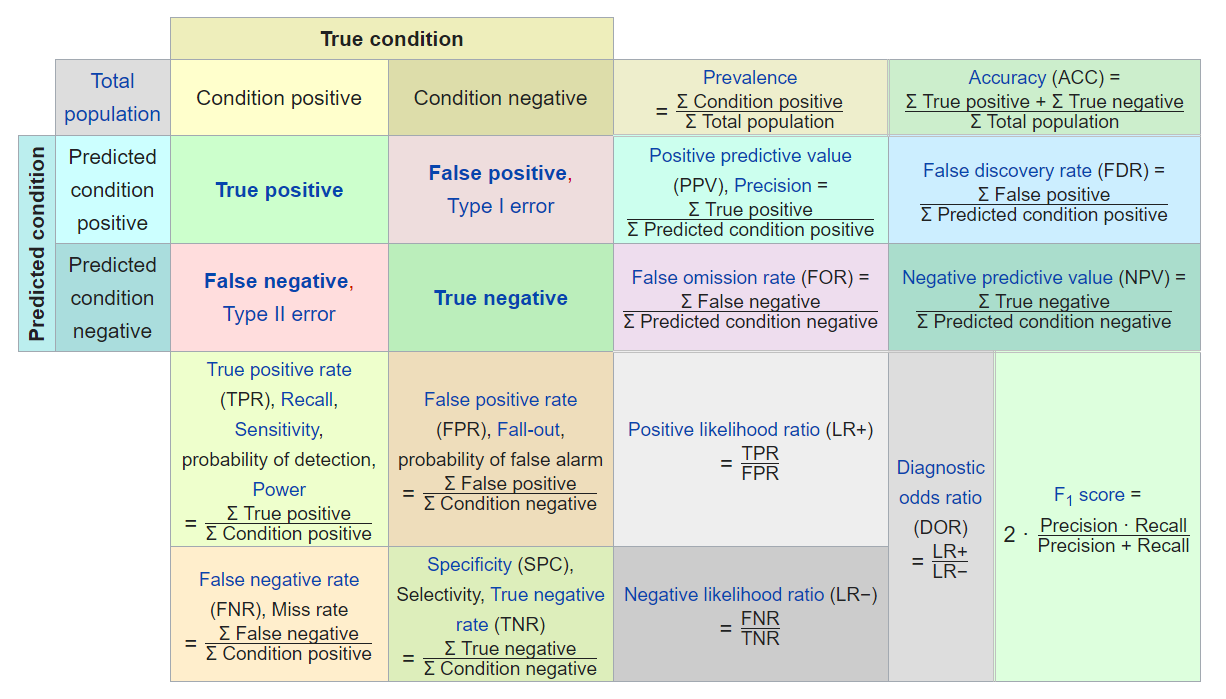

In [43]:
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[19,  0,  0,  1,  0,  1,  0],
       [ 0, 17,  0,  0,  0,  1,  0],
       [ 0,  0, 13,  0,  1,  0,  0],
       [ 0,  2,  0, 22,  0,  1,  0],
       [ 0,  0,  0,  1, 13,  0,  1],
       [ 3,  1,  0,  0,  0, 16,  3],
       [ 1,  0,  0,  0,  1,  1, 25]])

The largest values are on the diagonal, hence most predictions are correct, but there are mistakes (~15%). To visualise this more clearly as an image, we do two things. First, we normalise the matrix to 100, by dividing every value by the sum of its row (i.e. the number of actual items with a specific label). Second, we set the main diagonal to 0 in order to focus on the wrong predictions.


 ['Bear', 'Chicken', 'Deer', 'Eagle', 'Elephant', 'Monkey', 'Panda']


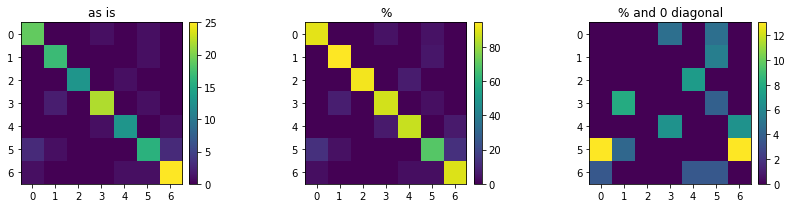

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

To draw proper conclusions, we often need to combine what we see in the confusion matrix with what we already know about the data. For example, we have quite a high percentage of eagles being classified as chickens. No offense to either eagles or chickens, but within this set they are similar. Also not all photos are very clear, perhaps we could look into different feature extraction methods or use a bit higher resolution images.

# Optimization
An 85% score is not bad for a first attempt and with a small dataset, but it can most likely be improved. As we already have a bunch of parameters to play with, it would be nice to automate the optimisation. In the next bit, we’ll set up a pipeline that preprocesses the data, trains the model and allows us to play with parameters more easily.

The pipeline fit method takes input data and transforms it in steps by sequentially calling the fit_transform method of each transformer. The data is passed from output to input until it reaches the end or the estimator if there is one. When the last item in the pipeline is an estimator, its fit method is called to train the model using the transformed data.

The resulting object can be used directly to make predictions. Test data is passed into the predict method, which calls the transform methods, followed by predict in the final step.

A run with our system shows that the result of the pipeline is identical to the result we had before.

In [45]:
from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Percentage correct:  86.80555555555556


 # Grid search
A huge advantage here is that, by using our pipeline, we can optimise both the transformations and the classifier in a single procedure. Additionally, instead of manually modifying parameters, we will use GridSearchCV. First we define a parameter grid, as shown in the cell below.

Transformers and estimators are indicated by their name, such as ‘classify’. Their parameters are indicated by ‘name__parameter’. Our parameter grid consists of two dictionaries. In the first, we try to improve the HOGTransformer. In the second, we test SGD vs. SVM. GridSearchCV will check all combinations within each dictionary, so we will have, 2 * 2 * 3 + 2 = 14, in total. Since the optimal preprocessing can vary with the model, it is often a good idea to gridsearch them together to find the global optimum. So, a better grid would be one where the hogify and classify settings are varied together (by placing them in a single dictionary).

$y(x)=\sum_{n=1}^{N} a_{n} k k\left(x_{n} x_{m}\right)+b$

In [46]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear')
         ]
    }
]

Next, we create a GridSearchCV object, passing the pipeline, and parameter grid. In addition we use cv=3. This parameter sets up cross validation. This means the data set is split into folds (3 in this case) and multiple training runs are done. In each run, one fold is used for validation and the others for training. This way the model can be validated and improved against a part of the training data, without touching the test data. For the final parameter, the score, we use ‘accuracy’, the percentage of true positive predictions. In other cases it might be more useful to use check false positives or another statistic.

The n_jobs parameter specifies the number of jobs we wish to run in parallel. We set its value to -1 to use all available cores. Note that this works in notebooks in Linux and possible OSX, but not in MS Windows.

To parallelise under Windows, it is necessary to run this code from a script, inside an if __name__ == ‘__main__’ clause. Further explanation can be found in the joblib documentation.

In [47]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:  1.7min finished


When the grid search is complete, the model will be trained a final time, using the full training set and the optimal parameters. We can dump the resulting object into a pickle file and load it when we want to use it. We can also use various methods to poke around in the results and the scores during the search. Note the trailing underscore in the properties: this is a scikit-learn convention, used for properties that only came into existence after a fit was performed.

In [48]:
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl');

In [49]:
# description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(memory=None,
         steps=[('grayify', RGB2GrayTransformer()),
                ('hogify',
                 HogTransformer(block_norm='L2-Hys', cells_per_block=(3, 3),
                                orientations=8, pixels_per_cell=(8, 8),
                                y=None)),
                ('scalify',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [54]:
Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', svm.SVC(kernel='linear'))])

Pipeline(memory=None,
         steps=[('grayify', RGB2GrayTransformer()),
                ('hogify',
                 HogTransformer(block_norm='L2-Hys', cells_per_block=(3, 3),
                                orientations=8, pixels_per_cell=(8, 8),
                                y=None)),
                ('scalify',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classify',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Additionally, run grid_res.cv_results_  to a get a detailed log of the gridsearch. The output is not shown here, as it is quite long. To be able to retrieve this log in sklearn version 0.21 and up, the return_train_score argument of GridSearchCV must be set to True.

In [55]:
# the highscore during the search
grid_res.best_score_

0.9055846422338569

In [56]:
pp.pprint(grid_res.best_params_)

{   'classify': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
    'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 8,
    'hogify__pixels_per_cell': (8, 8)}


Because the number of runs tends to explode quickly during a grid search, it is sometimes useful to use RandomizedSearchCV. This works in the same way as the grid search, but picks a specified (n_iter) number of random sets of parameters from the grid. This can be a good way to obtain a rough estimate of optimal parameters, before using a GridSearchCV for fine tuning.

Going back to our GridSearchCV results, our best results were obtained with a linear SVM. As a final test we use the model to make predictions for our test set, like we did above.

In [57]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  91.66666666666667


The accuracy went up from 85% to 92%. To get some more insight, we can compare the confusion matrices before and after optimisation. Note that the colour ranges are set to the larger of either two, for sake of comparison.

In [58]:
cmx_svm = confusion_matrix(y_test, best_pred)


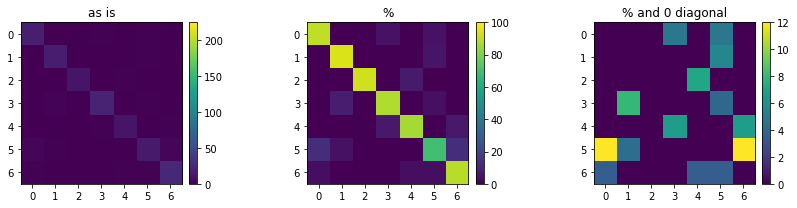

In [59]:
plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

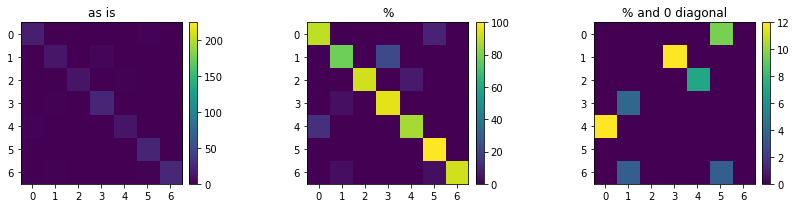

In [60]:
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)


On the far right, we can see where improvements took place (we turned chickens into eagles, it seems). Now we can try to look for specific issues in the data or perform feature extraction for further improvement. Fortunately, with the toolkit we built, we can let the computer do a fair amount of this work for us.



# Conclusion
In conclusion, we built a basic model to classify images based on their HOG features. In addition, we set up our tooling to systematically improve the model in an automated way. And most importantly, this methodology is generic and can be applied to all kinds of machine learning problems.

# References
-   Steegstra Patrick.Tutorial: image classification with scikit-learn,2018.   URLhttps://kapernikov.com/tutorial-image-classification-with-scikit-learn/.